In [98]:
!pip install git+https://github.com/danielegerbaldo/Mathematics-of-Epidemics-on-Networks.git

  Cloning https://github.com/danielegerbaldo/Mathematics-of-Epidemics-on-Networks.git to c:\users\daniele\appdata\local\temp\pip-req-build-2h6gdvpb


  Running command git clone -q https://github.com/danielegerbaldo/Mathematics-of-Epidemics-on-Networks.git 'C:\Users\Daniele\AppData\Local\Temp\pip-req-build-2h6gdvpb'


In [99]:
import networkx as nx
import matplotlib.pyplot as plt
import statistics
import sys
import random
import math
import EoN
import numpy as np
import powerlaw
import pandas as pd
import seaborn as sns
from collections import defaultdict
from scipy.integrate import odeint
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram
from collections import Counter
from scipy.stats import norm
from termcolor import colored, cprint
from matplotlib.patches import Rectangle

In [100]:
MORENO_RESIDENCE_HALL_FILE = 'networks/moreno_residence_hall.txt'

# Residence-Hall-Network

(Directed)

This directed network contains friendship ratings between 217 residents living at a residence hall located on the Australian National University campus. A node represents a person and 
an edge represents a friendship tie.  The friendships are weighted as follows from strongest to weakest tie:  5 (best friend), 4 (close friend), 3 (friend), 2, 1.

In [101]:
G = nx.read_weighted_edgelist(MORENO_RESIDENCE_HALL_FILE, create_using= nx.DiGraph, nodetype=int)
cprint(nx.info(G),'green')

DiGraph with 217 nodes and 2672 edges


In [102]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
nodes = G.nodes()
edges = G.edges()

# Utility Functions

In [103]:
def display_timeseries(t,ts_plots,data,title=None):
    fig_time = plt.figure(figsize=(30,10))
    data._display_time_series_(t=t,fig=fig_time,ts_plots = ts_plots, ts_list = None,timelabel=r'$t$') 
    fig_time.suptitle(title,x=0.72,fontsize=16,fontweight='bold')
    plt.show()
    plt.close(fig_time)

def display_graph(t,pos,data):
    kwargs = { 'pos':pos,'node_size':8000}
    network_ax, timeseries_axes = data.display(t,ts_plots=[], **kwargs)
    plt.show()
    plt.close()

def display_sirs_linegraph(t, S, I, R,title):
    fig_sirs_ax = plt.figure(figsize=(30,10))
    plt.plot(t, S, label = 'Susceptible', color='green')
    plt.plot(t, I, label = 'Infected', color='red')
    plt.plot(t, R, label = 'Recovered', color='grey')
    plt.xlabel('t')
    plt.ylabel('Nodes')
    plt.legend()
    plt.title(title,fontsize=16,fontweight='bold')
    plt.show()
    plt.close(fig_sirs_ax)        
    

In [104]:
def get_random_nodes(n):
    random_infected = []
    while(len(random_infected)<n):
        random_infected.append(random.randrange(1,217))
    return random_infected

### Sars-Cov-2 virus characteristics:

In [105]:
#R0 estimation study: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8436367/ https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8212592/
#Recovery rate study: https://www.nature.com/articles/s41467-020-20568-4

average_out_degree = statistics.mean([G.out_degree(n) for n in G.nodes])

#transmission rate per edge (probability of pass the disease to each of its susceptible neighbors)
original_cov_tau = 2.79/average_out_degree
alpha_cov_tau = 3.60/average_out_degree
delta_cov_tau = 5.08/average_out_degree

gamma = 1/8 #recovery rate per node (number of step when node is infected)


# SIR

In [106]:
# Documentation: https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.fast_SIR.html#EoN.fast_SIR

## Snapshot at time t

In [107]:
pos=nx.spring_layout(G, k=0.6, iterations=50)
# display_graph(0.1,pos,sir_data)

## Time series

### Random infected nodes with Sars-Cov-2:

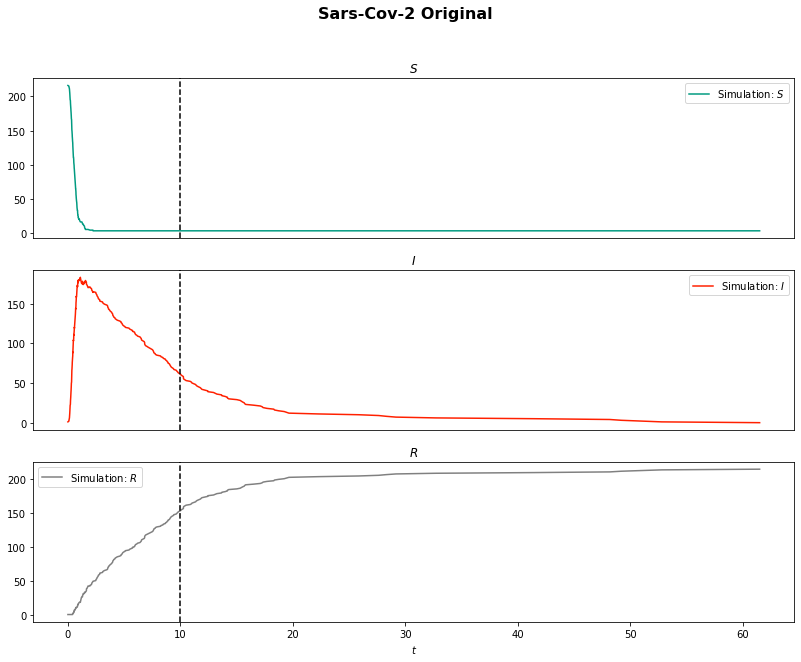

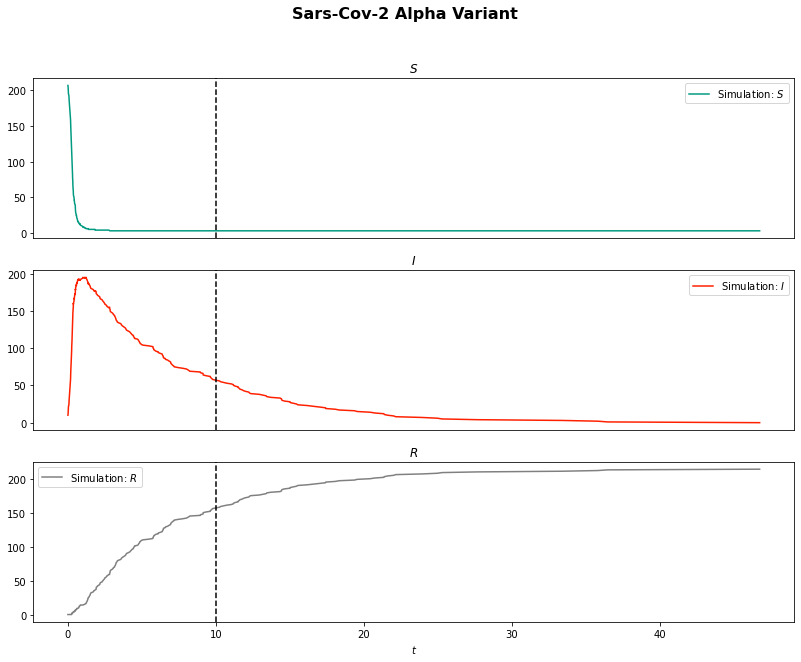

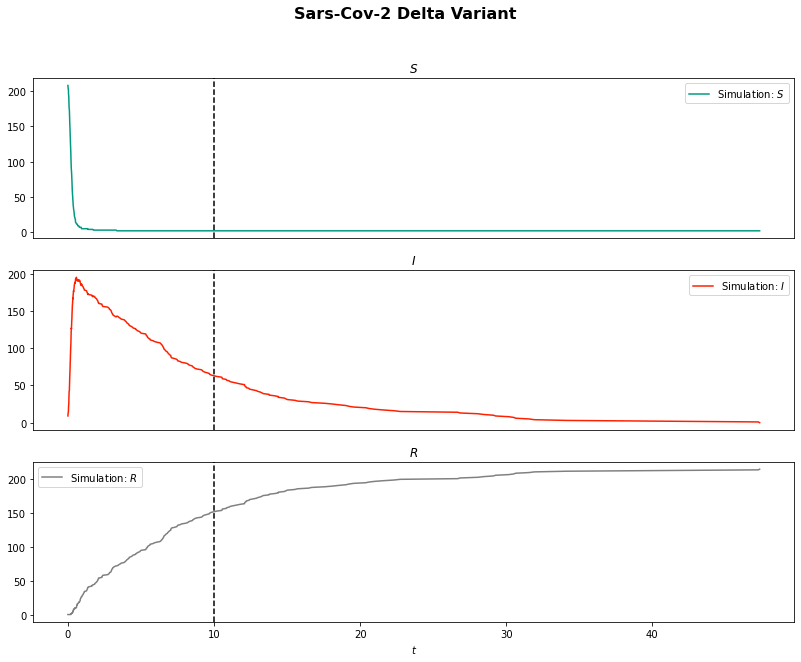

In [108]:
sir_data_orig = EoN.fast_SIR(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=70, return_full_data=True)
sir_data_alpha = EoN.fast_SIR(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(10), return_full_data=True)
sir_data_delta = EoN.fast_SIR(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(10), return_full_data=True)
display_timeseries(10, [['S'], ['I'], ['R']],sir_data_orig,"Sars-Cov-2 Original")
display_timeseries(10, [['S'], ['I'], ['R']],sir_data_alpha,"Sars-Cov-2 Alpha Variant")
display_timeseries(10, [['S'], ['I'], ['R']],sir_data_delta,"Sars-Cov-2 Delta Variant")

### Infecting hub first:

In [109]:
#Getting hub with highter out degree
H = G.copy()
max_out_degree_nodes = []
for node in G.nodes():
    if(len(max_out_degree_nodes)<7):
        max_out_degree_nodes.append(max(H.nodes, key=H.out_degree))
        H.remove_node(max(H.nodes, key=H.out_degree))

cprint('Out-Degree Hubs:', 'blue', end=' ')
cprint(max_out_degree_nodes,'green')

Out-Degree Hubs: [70, 184, 113, 120, 169, 27, 128]


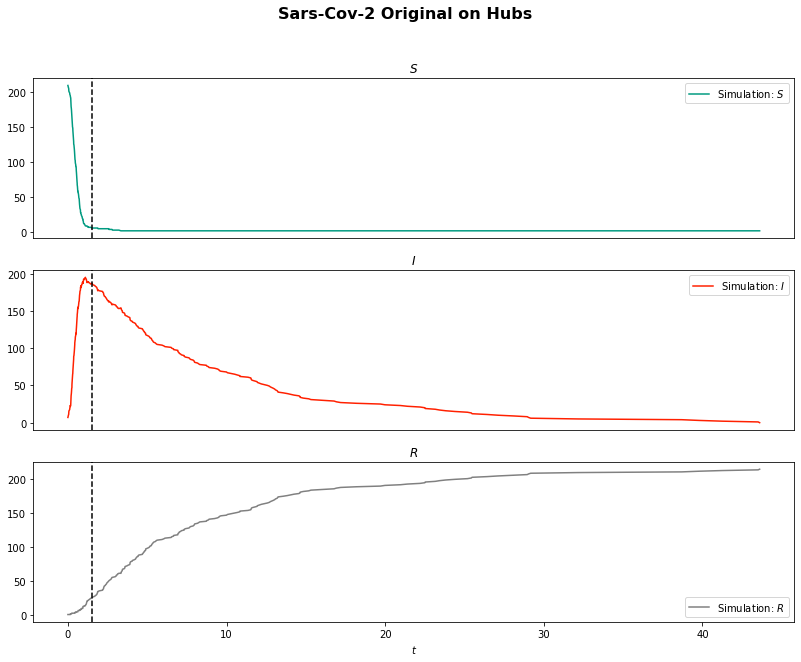

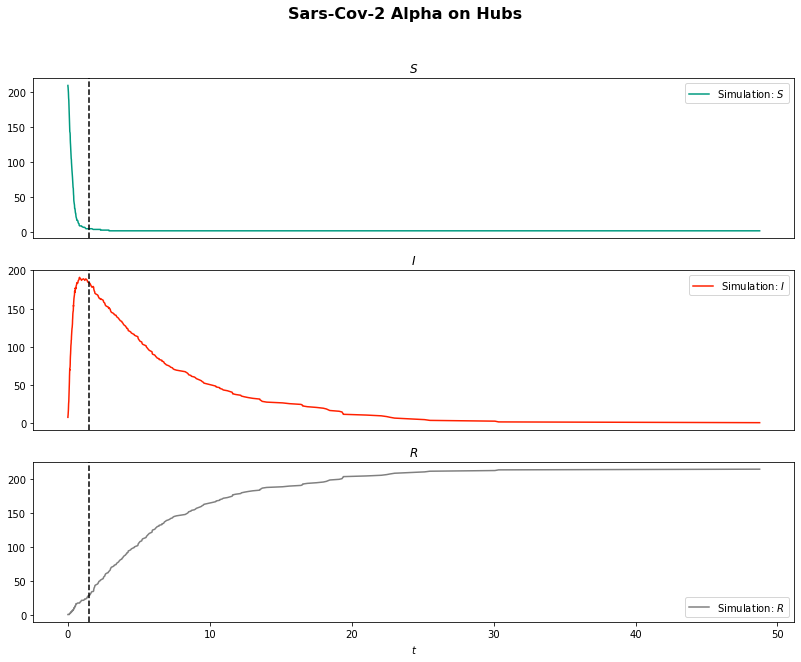

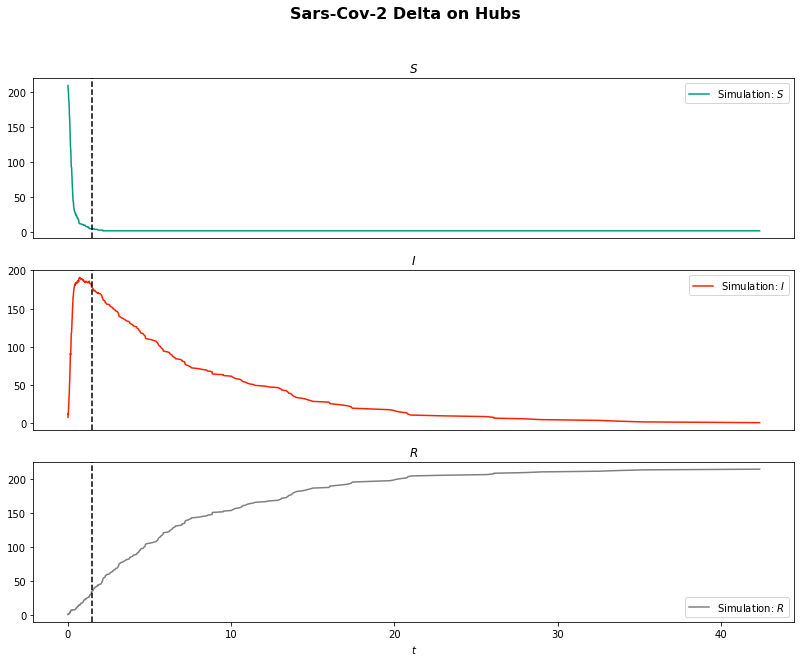

In [110]:
#display_graph(0.1,pos,sir_data_hub)

sir_data_orig_hub = EoN.fast_SIR(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, return_full_data=True)
sir_data_alpha_hub = EoN.fast_SIR(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, return_full_data=True)
sir_data_delta_hub = EoN.fast_SIR(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, return_full_data=True)
display_timeseries(1.5, [['S'], ['I'], ['R']],sir_data_orig_hub,"Sars-Cov-2 Original on Hubs")
display_timeseries(1.5, [['S'], ['I'], ['R']],sir_data_alpha_hub,"Sars-Cov-2 Alpha on Hubs")
display_timeseries(1.5, [['S'], ['I'], ['R']],sir_data_delta_hub,"Sars-Cov-2 Delta on Hubs")

### Vaccinate hub first

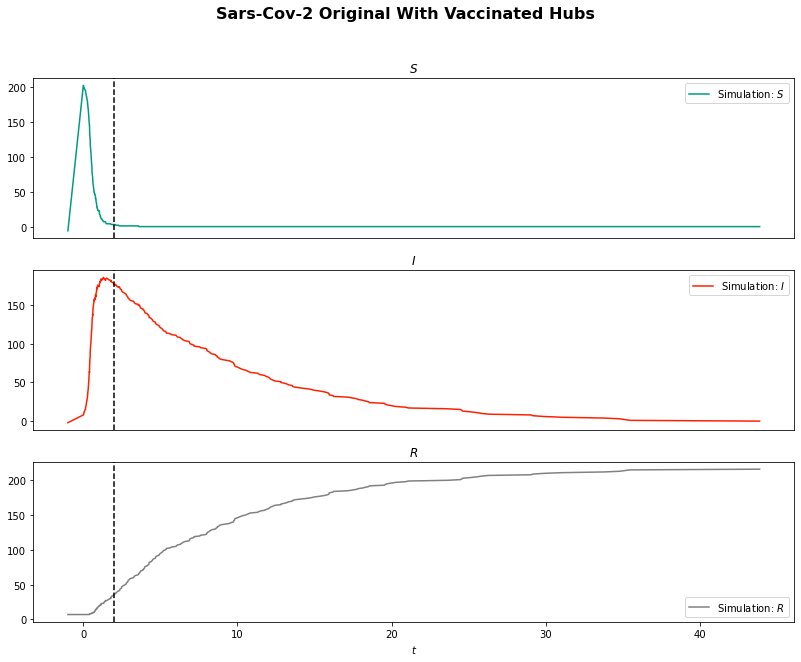

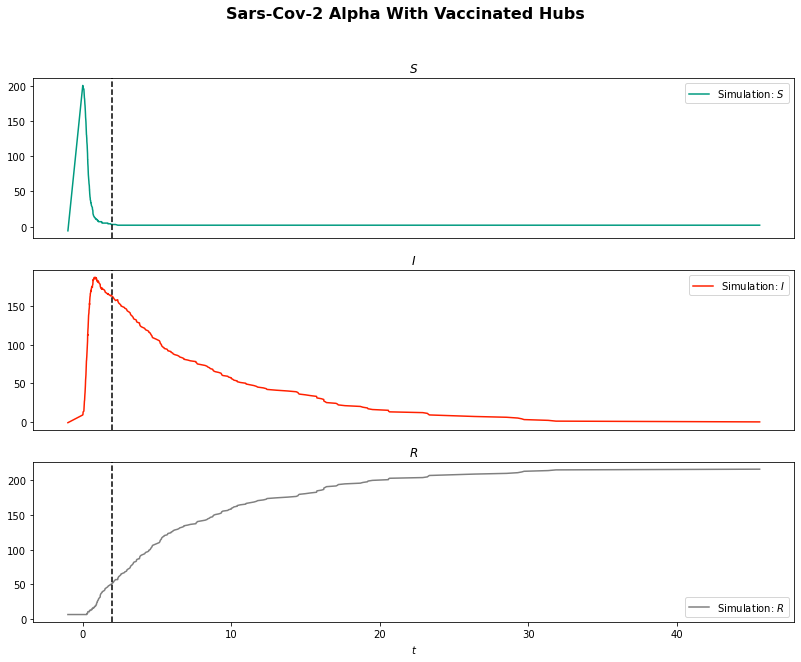

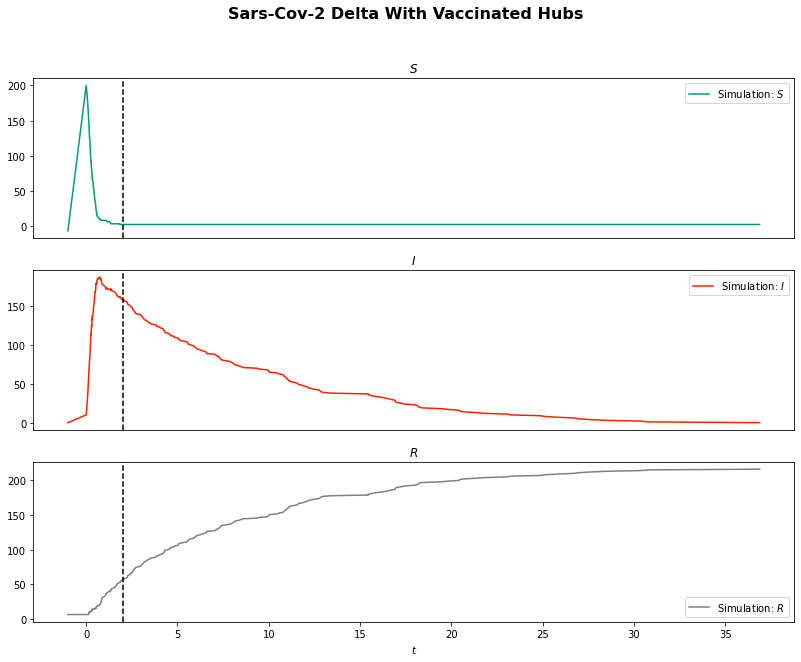

In [111]:
#display_graph(0,pos,sir_data_hub_out_seq)

sir_data_orig_hub_vax = EoN.fast_SIR(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(10), initial_recovereds=max_out_degree_nodes,return_full_data=True)
sir_data_alpha_hub_vax = EoN.fast_SIR(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(10), initial_recovereds=max_out_degree_nodes,return_full_data=True)
sir_data_delta_hub_vax = EoN.fast_SIR(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(10), initial_recovereds=max_out_degree_nodes,return_full_data=True)
display_timeseries(2, [['S'], ['I'], ['R']],sir_data_orig_hub_vax,"Sars-Cov-2 Original With Vaccinated Hubs")
display_timeseries(2, [['S'], ['I'], ['R']],sir_data_alpha_hub_vax,"Sars-Cov-2 Alpha With Vaccinated Hubs")
display_timeseries(2, [['S'], ['I'], ['R']],sir_data_delta_hub_vax,"Sars-Cov-2 Delta With Vaccinated Hubs")

## Animation

In [112]:
# #pos=nx.spring_layout(G, k=0.6, iterations=50)
# #pos= nx.kamada_kawai_layout(G)
# kwargs = { 'pos':pos,'node_size':8000}
# ani = sir_data_hub.animate(ts_plots=[],**kwargs)
# ani.save('SIRHub.mp4', fps=1, extra_args=['-vcodec', 'libx264'])

# SIS

In [113]:
# Documentation: https://epidemicsonnetworks.readthedocs.io/en/latest/examples/SIS_display.html

## Time series

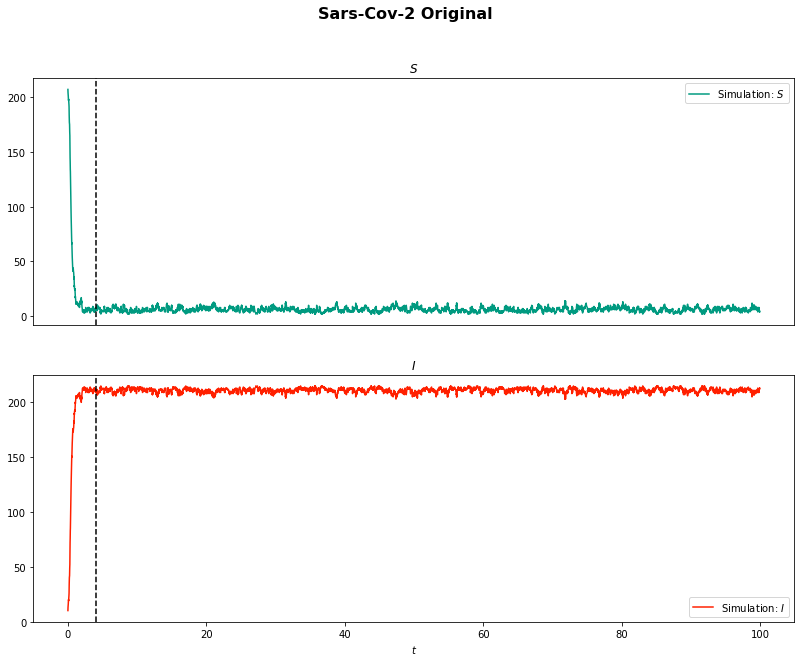

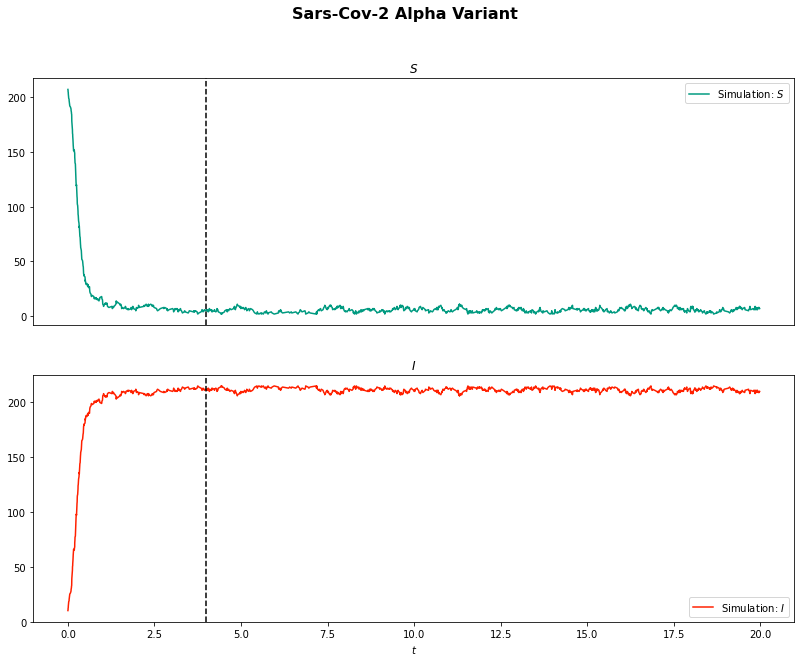

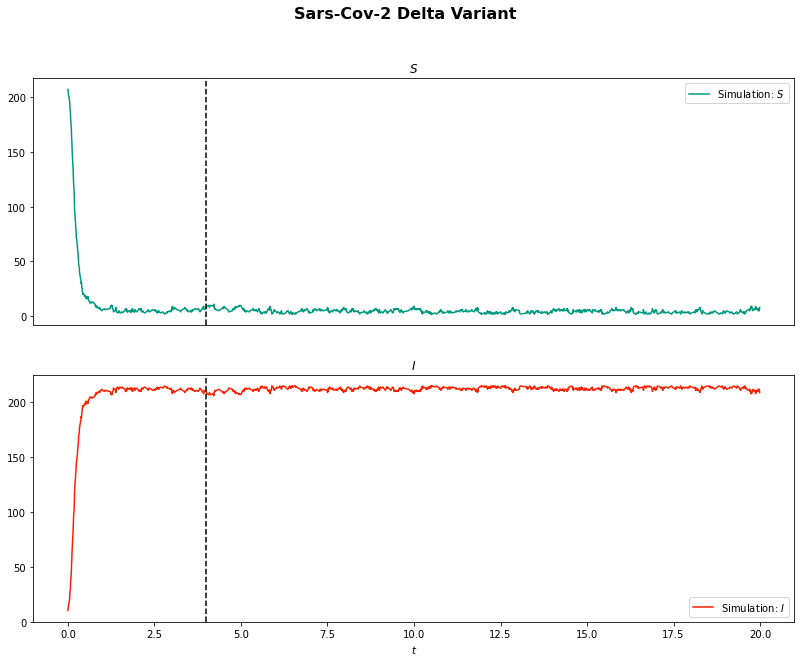

In [114]:
sis_data_orig = EoN.fast_SIS(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(10), return_full_data=True)
sis_data_alpha = EoN.fast_SIS(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(10), tmax=20, return_full_data=True)
sis_data_delta = EoN.fast_SIS(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=get_random_nodes(10), tmax=20, return_full_data=True)
display_timeseries(4, [['S'], ['I']],sis_data_orig,"Sars-Cov-2 Original")
display_timeseries(4, [['S'], ['I']],sis_data_alpha,"Sars-Cov-2 Alpha Variant")
display_timeseries(4, [['S'], ['I']],sis_data_delta,"Sars-Cov-2 Delta Variant")

## Infecting hub first

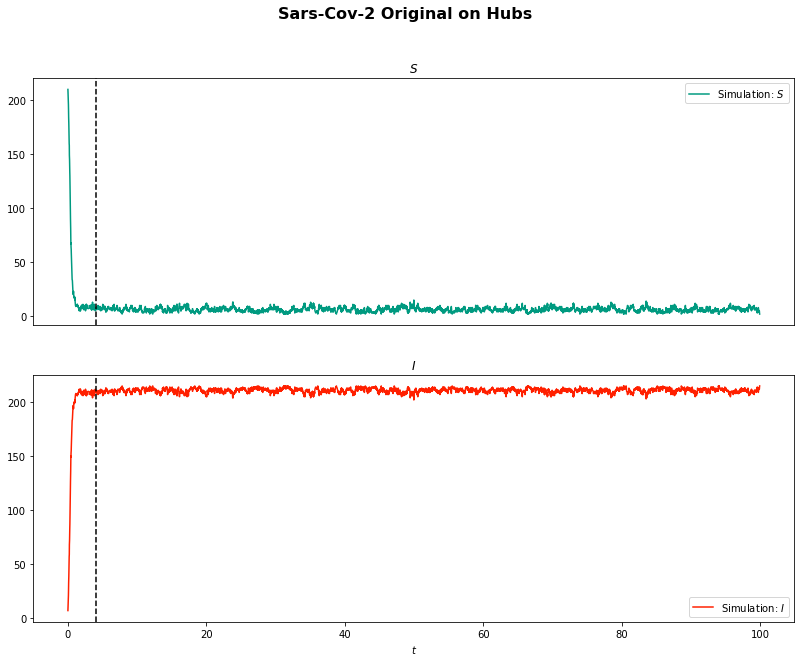

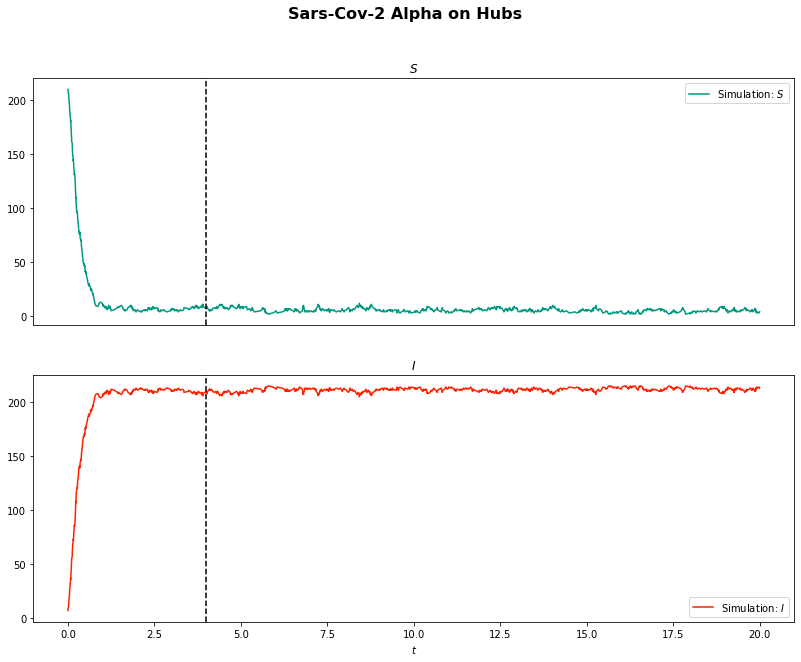

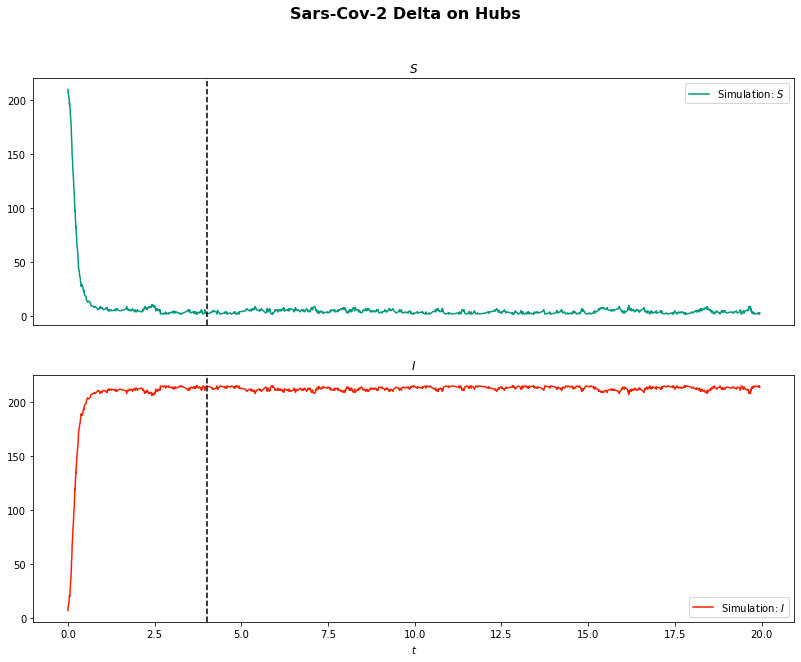

In [115]:
sis_data_orig_hub = EoN.fast_SIS(G, original_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, return_full_data=True)
sis_data_alpha_hub = EoN.fast_SIS(G, alpha_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, tmax=20, return_full_data=True)
sis_data_delta_hub = EoN.fast_SIS(G, delta_cov_tau, gamma, transmission_weight='weight',initial_infecteds=max_out_degree_nodes, tmax=20, return_full_data=True)
display_timeseries(4, [['S'], ['I']],sis_data_orig_hub,"Sars-Cov-2 Original on Hubs")
display_timeseries(4, [['S'], ['I']],sis_data_alpha_hub,"Sars-Cov-2 Alpha on Hubs")
display_timeseries(4, [['S'], ['I']],sis_data_delta_hub,"Sars-Cov-2 Delta on Hubs")

In [116]:
#ani = sis_data.animate()
#ani.save('SIS.mp4', fps=5, extra_args=['-vcodec', 'libx264'])

## SIRS

In [117]:
#Documentation: https://epidemicsonnetworks.readthedocs.io/en/latest/examples/SIRS.html
#               https://epidemicsonnetworks.readthedocs.io/en/latest/functions/EoN.Gillespie_simple_contagion.html#EoN.Gillespie_simple_contagion

In [118]:
def run_sirs(gamma,mu,tau,initial_infected, initial_recovered=[], tmax=10,return_full_data=True):
    H = nx.DiGraph()  #DiGraph showing possible transitions that don't require an interaction
    H.add_edge('I', 'R', rate = gamma)   #I->R
    H.add_edge('R', 'S', rate = 1/mu)   #R->S

    J = nx.DiGraph()    #DiGraph showing transition that does require an interaction.
    J.add_edge(('I', 'S'), ('I', 'I'), rate = tau, weight_label='weight')  #IS->II

    IC = defaultdict(lambda: 'S')
    for node in initial_infected:
        IC[node] = 'I'

    for node in initial_recovered:
        IC[node] = 'R'    

    return_statuses = ('S', 'I', 'R')

    return EoN.Gillespie_simple_contagion(G, H, J, IC, return_statuses=return_statuses,tmax=tmax,return_full_data=return_full_data)



## Time series

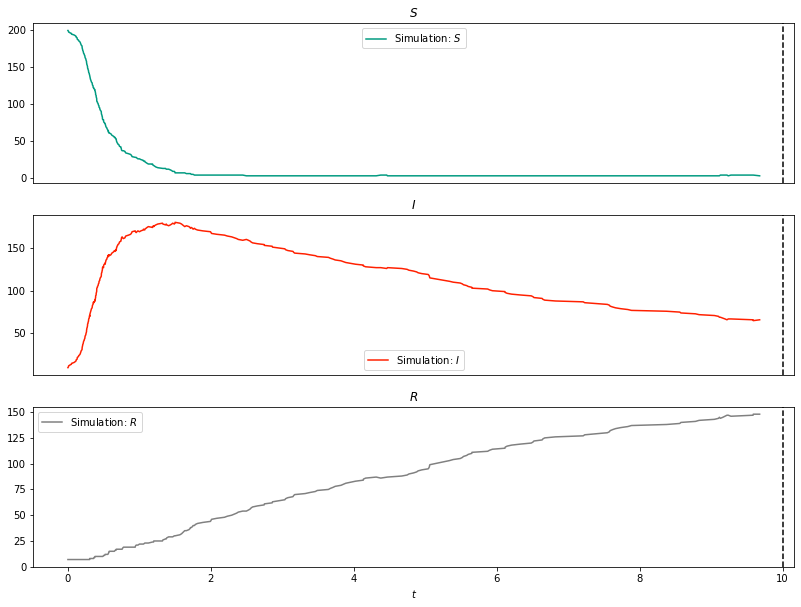

In [119]:
fig_sirs_time = plt.figure(figsize=(30,10))
run_sirs(gamma,200,original_cov_tau,get_random_nodes(10), max_out_degree_nodes, tmax=10)._display_time_series_(t=10,fig=fig_sirs_time,ts_plots = [['S'], ['I'], ['R']], ts_list = None,timelabel=r'$t$')
plt.show()
plt.close(fig_sirs_time)

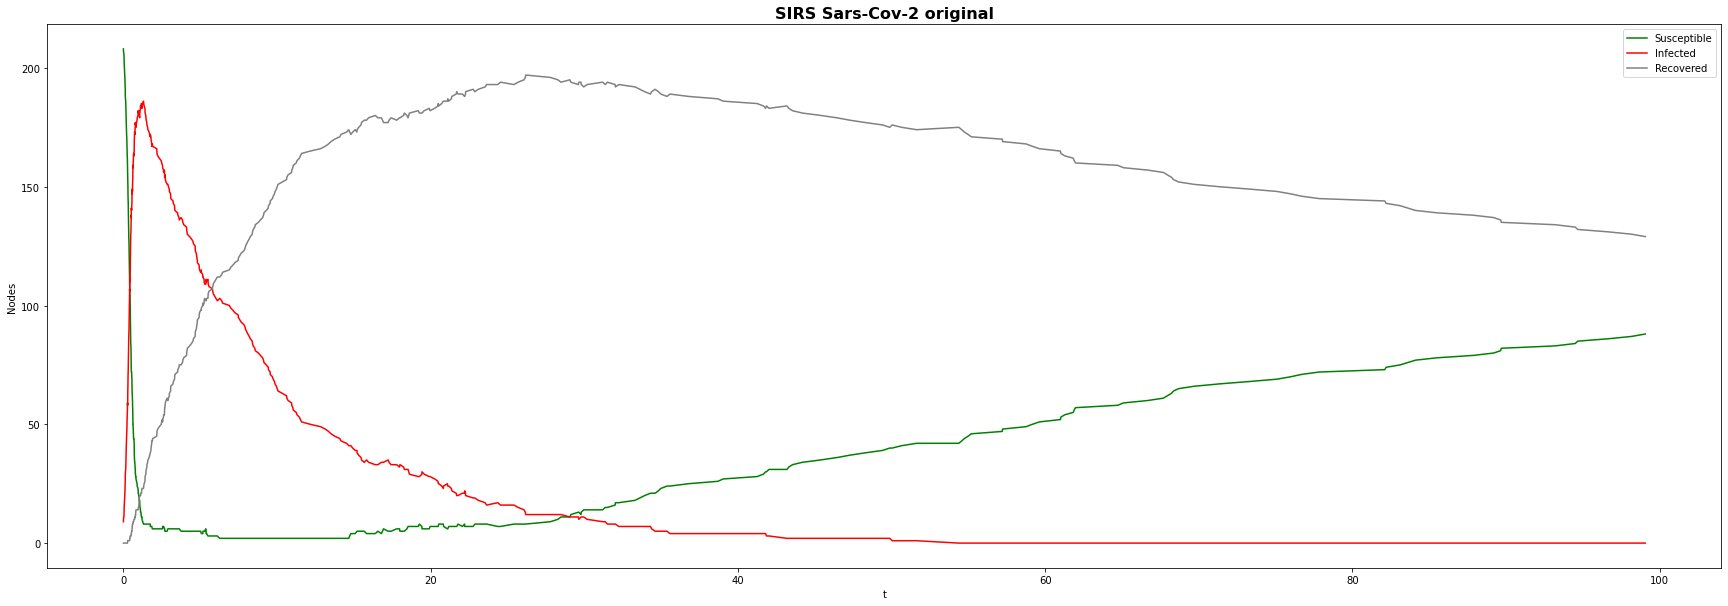

In [126]:
t, S, I, R = run_sirs(gamma,200,original_cov_tau,get_random_nodes(10), tmax=100, return_full_data=False)

display_sirs_linegraph(t, S, I, R,"SIRS Sars-Cov-2 original")

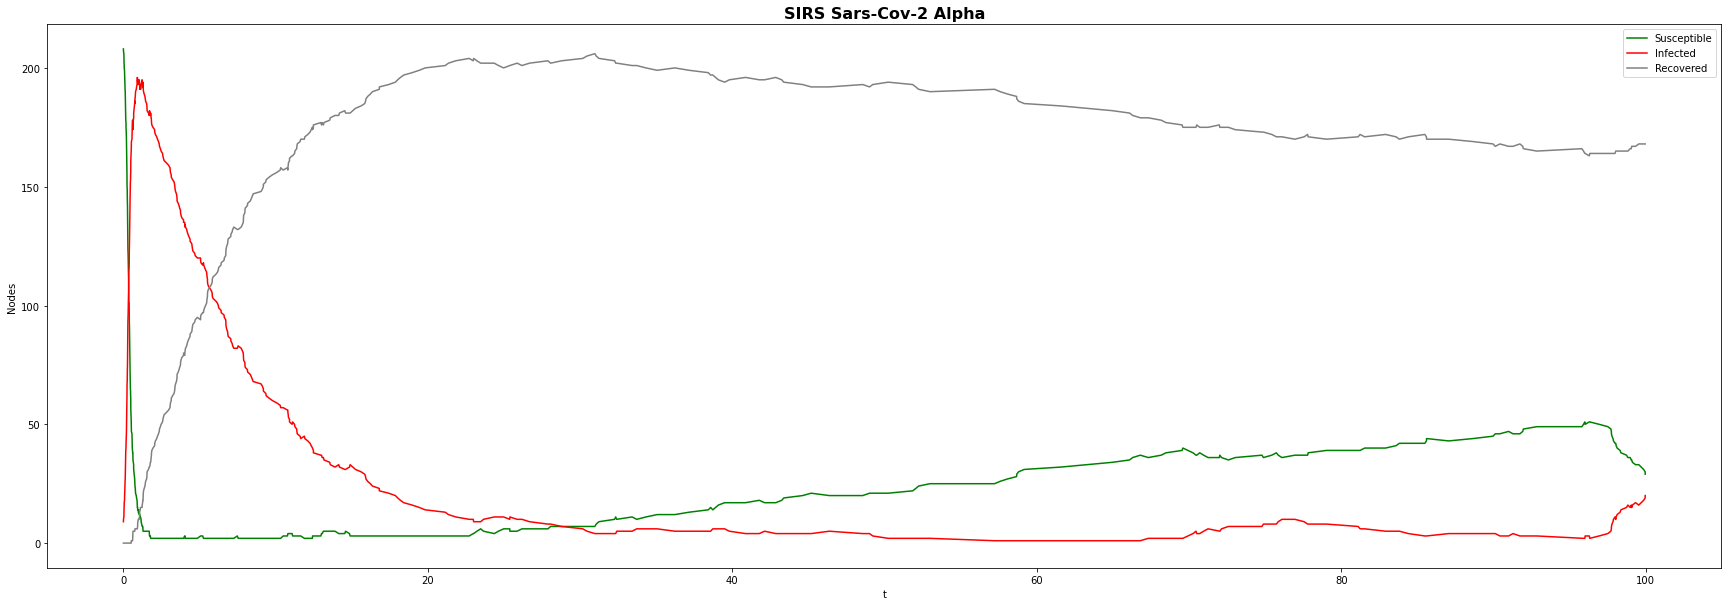

In [121]:
t, S, I, R = run_sirs(gamma,200,alpha_cov_tau,get_random_nodes(10), get_random_nodes(0), tmax=100, return_full_data=False)

display_sirs_linegraph(t, S, I, R,"SIRS Sars-Cov-2 Alpha")

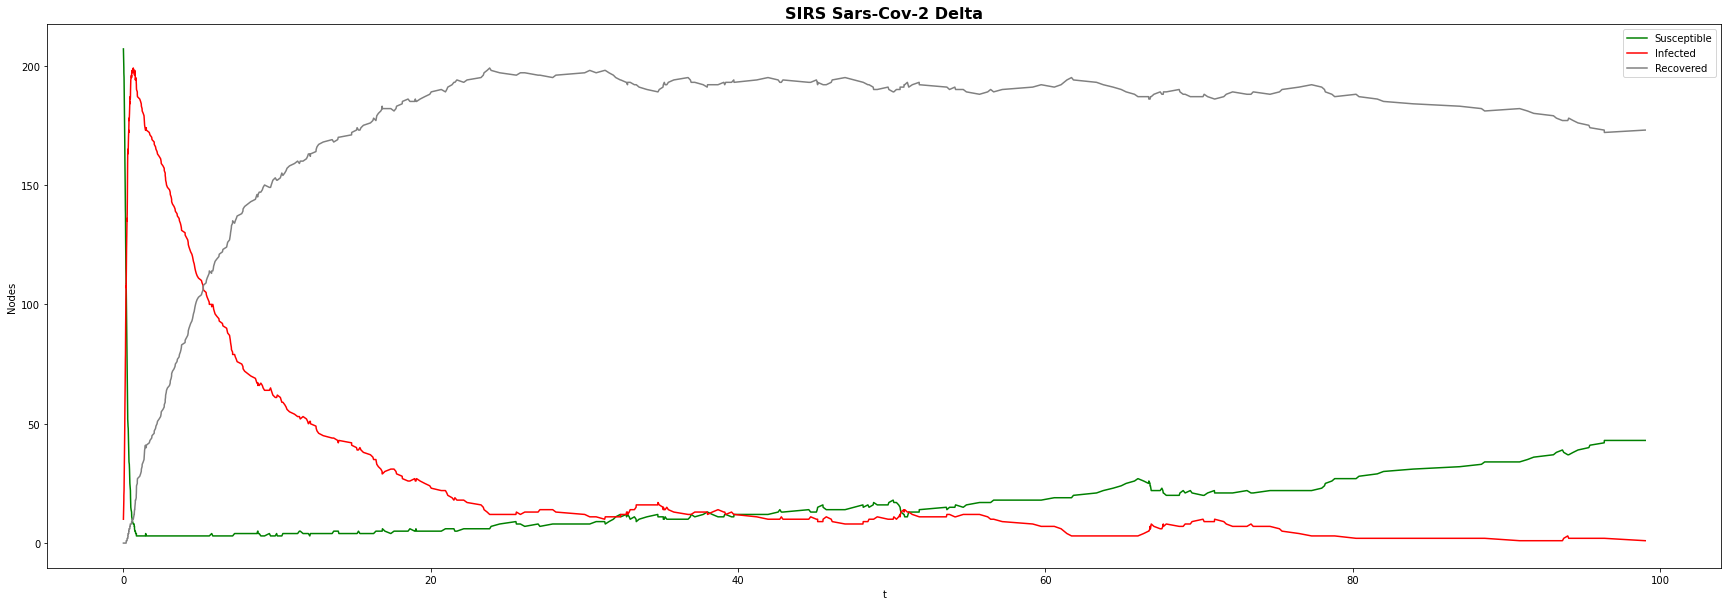

In [122]:
t, S, I, R = run_sirs(gamma,200,delta_cov_tau,get_random_nodes(10), get_random_nodes(0), tmax=100, return_full_data=False)

display_sirs_linegraph(t, S, I, R,"SIRS Sars-Cov-2 Delta")

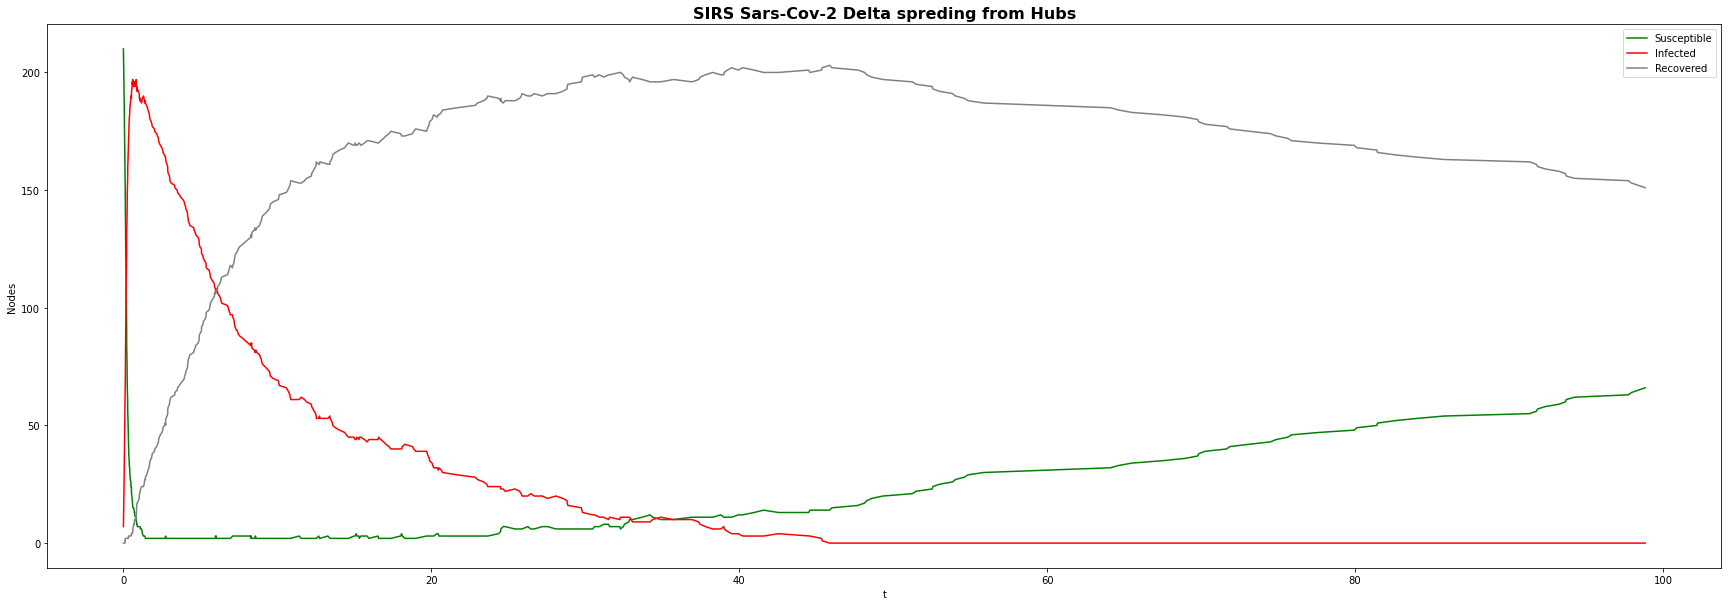

In [123]:
t, S, I, R = run_sirs(gamma,200,delta_cov_tau,max_out_degree_nodes, get_random_nodes(0), tmax=100, return_full_data=False)

display_sirs_linegraph(t, S, I, R,"SIRS Sars-Cov-2 Delta spreding from Hubs")

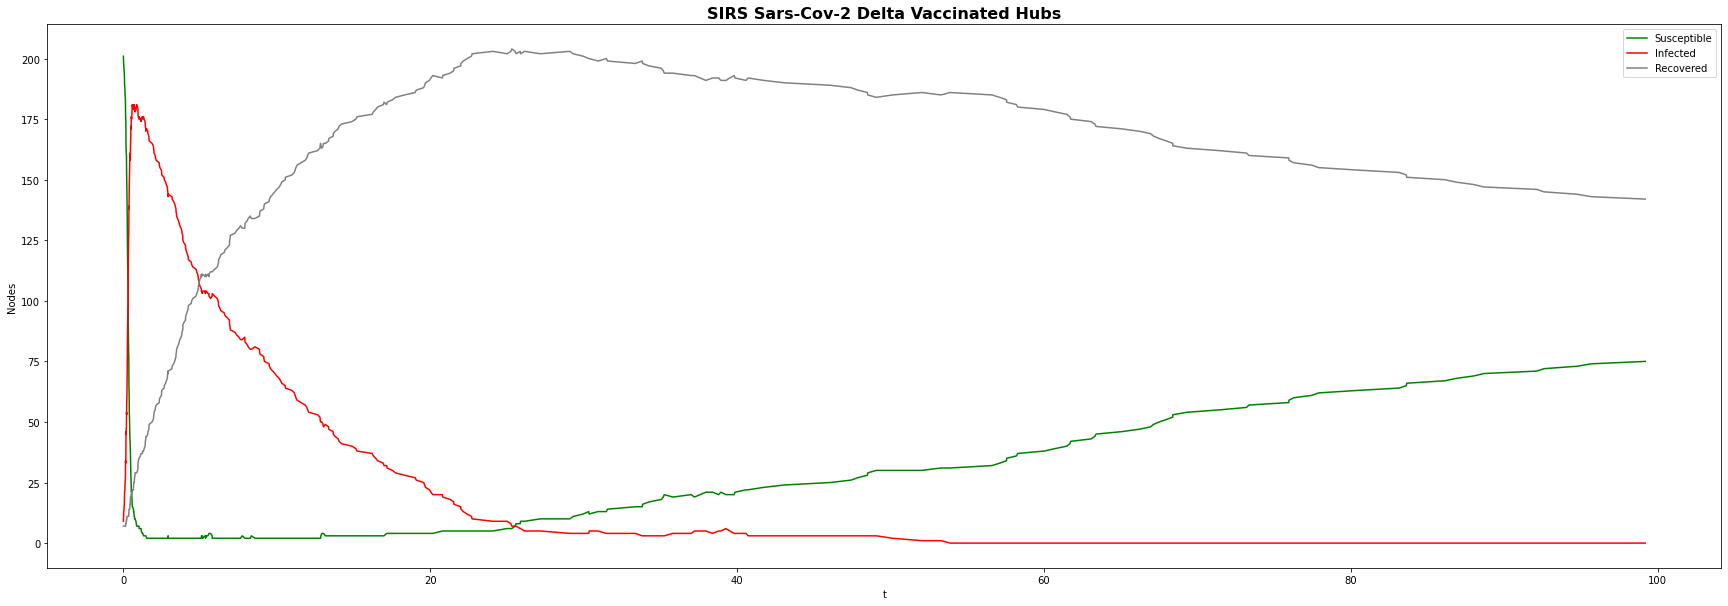

In [124]:
t, S, I, R = run_sirs(gamma,200,delta_cov_tau,get_random_nodes(10), max_out_degree_nodes, tmax=100, return_full_data=False)

display_sirs_linegraph(t, S, I, R,"SIRS Sars-Cov-2 Delta Vaccinated Hubs")

In [125]:
#ani = sirs_data.animate()
#ani.save('SIRS.mp4', fps=5, extra_args=['-vcodec', 'libx264'])